# Исследование мира метал-музыки. Описание проекта.


Ссылка на Kaggle: https://www.kaggle.com/datasets/mrpantherson/metal-by-nation

Автор собрал информацию музыкальных группах, играющих метал, с сайта http://metalstorm.net/

Исследования этих данных в рамках данного проекта поможет разобраться нам в закономерностях мира тяжёлой музыки! \m/

# Загрузка и обработка данных.

Загрузим необходимые библиотеки и сами данные.

In [145]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [146]:
df_metal = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Datasets/Metal/metal_bands_2017.csv',
    sep=',',
    encoding='latin-1',
)

Смотрим информацию о датасете.

In [147]:
df_metal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   band_name   5000 non-null   object
 2   fans        5000 non-null   int64 
 3   formed      5000 non-null   object
 4   origin      4992 non-null   object
 5   split       5000 non-null   object
 6   style       5000 non-null   object
dtypes: int64(2), object(5)
memory usage: 273.6+ KB


In [148]:
df_metal.head()

,Unnamed: 0,band_name,fans,formed,origin,split,style
0,0,Iron Maiden,4195,1975,United Kingdom,-,"New wave of british heavy,Heavy"
1,1,Opeth,4147,1990,Sweden,1990,"Extreme progressive,Progressive rock,Progressive"
2,2,Metallica,3712,1981,USA,-,"Heavy,Bay area thrash"
3,3,Megadeth,3105,1983,USA,1983,"Thrash,Heavy,Hard rock"
4,4,Amon Amarth,3054,1988,Sweden,-,Melodic death


Датасет содержит следующую информацию:
- band_name - название группы;
- fans - количество фанатов (голосов) на сайте;
- formed - год основания музыкальной группы;
- split - год распада музыкальной группы (прочерк обозначает, что группа активная до сих пор);
- style - список поджанров, которыми можно охарактеризовать творчество исполнителей.

Столбец Unnamed: 0 явно ошибочный и дублирует индексы, удалим его.

In [149]:
df_metal = df_metal.drop('Unnamed: 0', axis=1)

Посмотрим пропуски по столбцам.

In [150]:
pd.DataFrame(
    round(
        df_metal.isna().mean() * 100,
    )
).style.background_gradient('coolwarm')

,0
band_name,0.000000
fans,0.000000
formed,0.000000
origin,0.000000
split,0.000000
style,0.000000


Заполним пропуски в графе страны группы на заглушку 'unknown'.

In [151]:
df_metal['origin'].fillna('unknown', inplace=True)

Удалим ошибочные строки с прочекром вместом года основания.

In [152]:
df_metal = df_metal[df_metal['formed'] != '-']

Заполним прочерки в столбце split, в котором указан год распада группы, на 2017-ый год (год сбора информации).

In [153]:
df_metal['split'] = df_metal['split'].replace('-', 2017)

Смотрим количество явные дубликатов в данных.

In [154]:
df_metal.duplicated().sum()

50

Удаляем их.

In [155]:
df_metal = df_metal.drop_duplicates()

Смотрим неявные дубликаты по названию группы.

In [156]:
duplicates = df_metal[df_metal.duplicated(subset=['band_name'], keep=False)]
duplicates

,band_name,fans,formed,origin,split,style
1713,Michael Schenker's Temple Of Rock,25,1979,Germany,1979,Hard rock
4734,Michael Schenker's Temple Of Rock,1,2011,Germany,2017,"Heavy,Hard rock"


Одна и та же группа. Удаляем первое (ошибочное) упоминание, а количество голосов перекидываем во вторую найденную строчку.

In [157]:
df_metal = df_metal.drop(1713)
df_metal.at[4734, 'fans'] = 26

Меняем тип данных у годов основания и распада групп на целые числа.

In [158]:
df_metal['formed'] = df_metal['formed'].astype(int)

In [159]:
df_metal['split'] = df_metal['split'].astype(int)

Добавляем столбец, в котором будет храниться количество лет у каждой группы, в течение которых она была активна. На случай ошибок в данных, если будет получаться отрицательное число, проставим 0.

In [160]:
df_metal['num_of_active_yrs'] = (df_metal['split'] - df_metal['formed']).apply(
    lambda x: max(x, 0)
)

Посмотрим, как распределяется длина срока жизни метал групп.

In [161]:
df_metal['num_of_active_yrs'].describe()

count    4945.000000
mean        7.741557
std         9.929767
min         0.000000
25%         0.000000
50%         1.000000
75%        14.000000
max        53.000000
Name: num_of_active_yrs, dtype: float64

## Выводы по разделу.

- Загружены все необходимые библиотеки и данные.
- Рассмотрена информация об исследуемом датасете.
- Удалён ошибочный столбец, дублирующий индексы.
- Пропуски в столбце с родной страной каждой из музыкальных групп заполнены заглушкой 'unknown'.
- Дубликаты удалены.
- Строки с прочерком вместо года основания группы удалены.
- Столбцы с годом основания и распады группа приведены к правильному типу данных (int).
- Создан столбец, в котором хранится количество лет жизни каждой из музыкальных грпупп.
- Из наших данных выходит, что половина рассматриваемых групп распалась в тот же год, что и были созданы. Возможно, такое значение вызвано ошибками в собранных данных, однако факт: многие метал-группы как создаются, так быстро и распадаются. Среднеарифметический срок жизни группы из нашего датасета в районе семи лет и девяти месяцев. Максимальный срок жизни - 53 года.

# Определение самых популярных поджанров.

В общее понятие метала входит огромное количество поджанров, многие из которых стилистически достаточно удалены друг от друга.

Посмотрим, какие поджанры превалируют в нашем датасете. Для этого сначала получим их полный список.

In [162]:
all_styles = ' '.join(df_metal['style'].dropna().astype(str))
all_styles

"New wave of british heavy,Heavy Extreme progressive,Progressive rock,Progressive Heavy,Bay area thrash Thrash,Heavy,Hard rock Melodic death Thrash Progressive death,Death,Progressive thrash Progressive Doom,Heavy,Hard rock Symphonic power,Gothic,Symphonic Extreme power Heavy,Hard rock Power,Speed Gothenburg,Alternative Heavy,Groove thrash,Groove metal Gothenburg Atmospheric black,Neofolk Extreme folk Gothenburg Blackened doom,Death doom,Alternative rock,Gothic doom Death,Black,Blackened death Symphonic black,Black Teutonic thrash Extreme power Melodic death Death,Melodic death,Folk,Progressive Symphonic power Progressive,Alternative Speed,Power Bay area thrash Symphonic Death,Black Groove thrash Heavy,Us power Death doom,Atmospheric rock,Doom Progressive,Symphonic power Celtic folk,Gothenburg Progressive death Industrial Power Progressive stoner,Progressive sludge Brutal death,Technical death Alternative,Death,Groove thrash,Thrash Folk,Gothic black,Gothic,Symphonic black,Black Death,S

Получили очень длинную строку, где перечисленные все упомянутые поджанры. Для начала неплохо, но лучше всё-таки приведём в вид списка.

In [163]:
genre_list = all_styles.split(',')
genre_list

['New wave of british heavy',
 'Heavy Extreme progressive',
 'Progressive rock',
 'Progressive Heavy',
 'Bay area thrash Thrash',
 'Heavy',
 'Hard rock Melodic death Thrash Progressive death',
 'Death',
 'Progressive thrash Progressive Doom',
 'Heavy',
 'Hard rock Symphonic power',
 'Gothic',
 'Symphonic Extreme power Heavy',
 'Hard rock Power',
 'Speed Gothenburg',
 'Alternative Heavy',
 'Groove thrash',
 'Groove metal Gothenburg Atmospheric black',
 'Neofolk Extreme folk Gothenburg Blackened doom',
 'Death doom',
 'Alternative rock',
 'Gothic doom Death',
 'Black',
 'Blackened death Symphonic black',
 'Black Teutonic thrash Extreme power Melodic death Death',
 'Melodic death',
 'Folk',
 'Progressive Symphonic power Progressive',
 'Alternative Speed',
 'Power Bay area thrash Symphonic Death',
 'Black Groove thrash Heavy',
 'Us power Death doom',
 'Atmospheric rock',
 'Doom Progressive',
 'Symphonic power Celtic folk',
 'Gothenburg Progressive death Industrial Power Progressive stoner'

Уже лучше. Но какие-то слова в этом списке написаны с заглавных букв, какие-то со строчных. Сделаем все строчными.

In [164]:
lowercase_genre_list = [word.lower() for word in genre_list]
lowercase_genre_list

['new wave of british heavy',
 'heavy extreme progressive',
 'progressive rock',
 'progressive heavy',
 'bay area thrash thrash',
 'heavy',
 'hard rock melodic death thrash progressive death',
 'death',
 'progressive thrash progressive doom',
 'heavy',
 'hard rock symphonic power',
 'gothic',
 'symphonic extreme power heavy',
 'hard rock power',
 'speed gothenburg',
 'alternative heavy',
 'groove thrash',
 'groove metal gothenburg atmospheric black',
 'neofolk extreme folk gothenburg blackened doom',
 'death doom',
 'alternative rock',
 'gothic doom death',
 'black',
 'blackened death symphonic black',
 'black teutonic thrash extreme power melodic death death',
 'melodic death',
 'folk',
 'progressive symphonic power progressive',
 'alternative speed',
 'power bay area thrash symphonic death',
 'black groove thrash heavy',
 'us power death doom',
 'atmospheric rock',
 'doom progressive',
 'symphonic power celtic folk',
 'gothenburg progressive death industrial power progressive stoner'

Многие поджанры сами являются целым списком (в обычном смысле) поджанров. Дальше встаёт вопрос: оставить всё как есть или пытаться разбить всё на отдельные слова, получив при этом много лишнего мусора. Попробуем оба этих подхода, а потом сравним результат.

Создаём счётчик.

In [165]:
genre_counts = pd.Series(lowercase_genre_list).value_counts()

In [166]:
genre_counts.head(20)

heavy                27
death                27
sludge               25
doom                 24
thrash               22
hardcore             20
crust                17
progressive          16
post-metal           13
industrial           13
melodic death        13
black                13
hard rock            12
death doom           12
progressive death    12
folk                 11
power                11
thrash black         10
gothic               10
death black           9
dtype: int64

Строим облако слов.

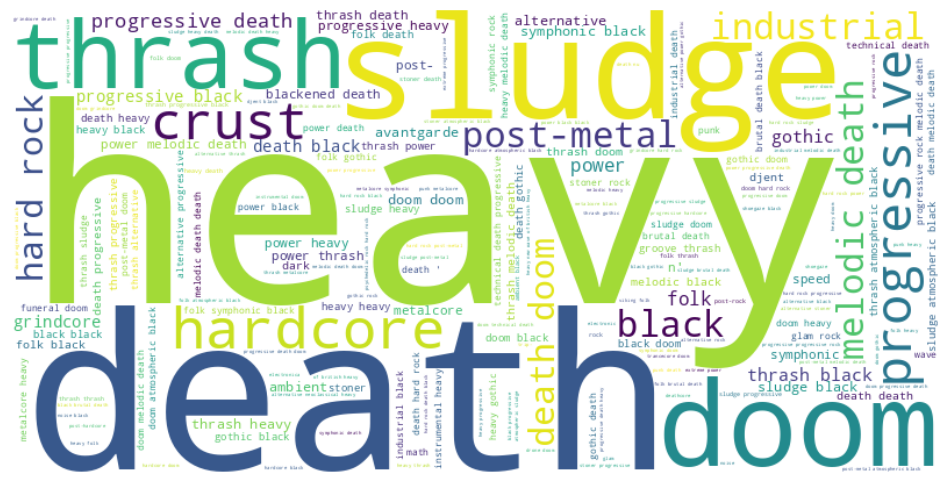

In [167]:
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(genre_counts)

sns.set(rc={'figure.figsize':(12, 8)})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

А теперь второй вариант развития событий: разбиваем всё на отдельные слова.

In [168]:
def split_list_of_strings(strings):
    words = []
    for string in strings:
        words.extend(string.split())
    return words

single_words = split_list_of_strings(lowercase_genre_list)

single_words

['new',
 'wave',
 'of',
 'british',
 'heavy',
 'heavy',
 'extreme',
 'progressive',
 'progressive',
 'rock',
 'progressive',
 'heavy',
 'bay',
 'area',
 'thrash',
 'thrash',
 'heavy',
 'hard',
 'rock',
 'melodic',
 'death',
 'thrash',
 'progressive',
 'death',
 'death',
 'progressive',
 'thrash',
 'progressive',
 'doom',
 'heavy',
 'hard',
 'rock',
 'symphonic',
 'power',
 'gothic',
 'symphonic',
 'extreme',
 'power',
 'heavy',
 'hard',
 'rock',
 'power',
 'speed',
 'gothenburg',
 'alternative',
 'heavy',
 'groove',
 'thrash',
 'groove',
 'metal',
 'gothenburg',
 'atmospheric',
 'black',
 'neofolk',
 'extreme',
 'folk',
 'gothenburg',
 'blackened',
 'doom',
 'death',
 'doom',
 'alternative',
 'rock',
 'gothic',
 'doom',
 'death',
 'black',
 'blackened',
 'death',
 'symphonic',
 'black',
 'black',
 'teutonic',
 'thrash',
 'extreme',
 'power',
 'melodic',
 'death',
 'death',
 'melodic',
 'death',
 'folk',
 'progressive',
 'symphonic',
 'power',
 'progressive',
 'alternative',
 'speed',
 

Дальше аналогично создаём счётчик и строим облако слов.

In [169]:
genre_counts_2 = pd.Series(single_words).value_counts()
genre_counts_2

death          1339
black          1156
progressive     703
doom            678
heavy           556
               ... 
ragga             1
noisecore         1
cyber             1
krautrock         1
j-rock            1
Length: 123, dtype: int64

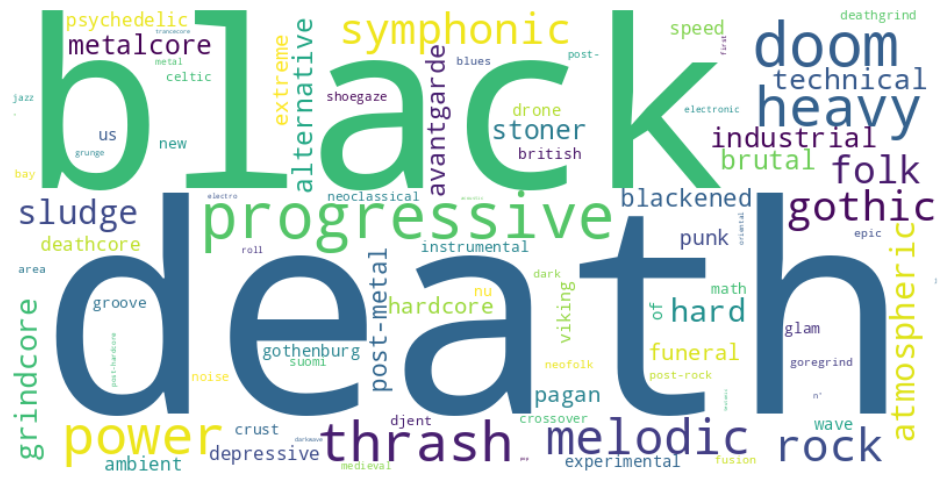

In [170]:
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(genre_counts_2)

sns.set(rc={'figure.figsize':(12, 8)})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Выводы по разделу.

Как мне кажется, по итогу два рассмотренных подхода для определения самых популярных в нашем датасете поджанров даже дополнили друг друга. Мы видим, что в нашем датасете собрались действительно тяжёлые по своему звучанию группы, в 'персональном зачёте' лидируют Death, Black, Progressive, Doom и Heavy. Если же нам интересны сочетания поджанров, то можно увидеть, что самыми распространёнными являются Melodic Death, Hard Rock, Death Doom, Progressive Death и Thrash Black.
       

# Построение графиков.

Создадим топ-10 долгожителей по сроку непрерывной активности исполнителей.

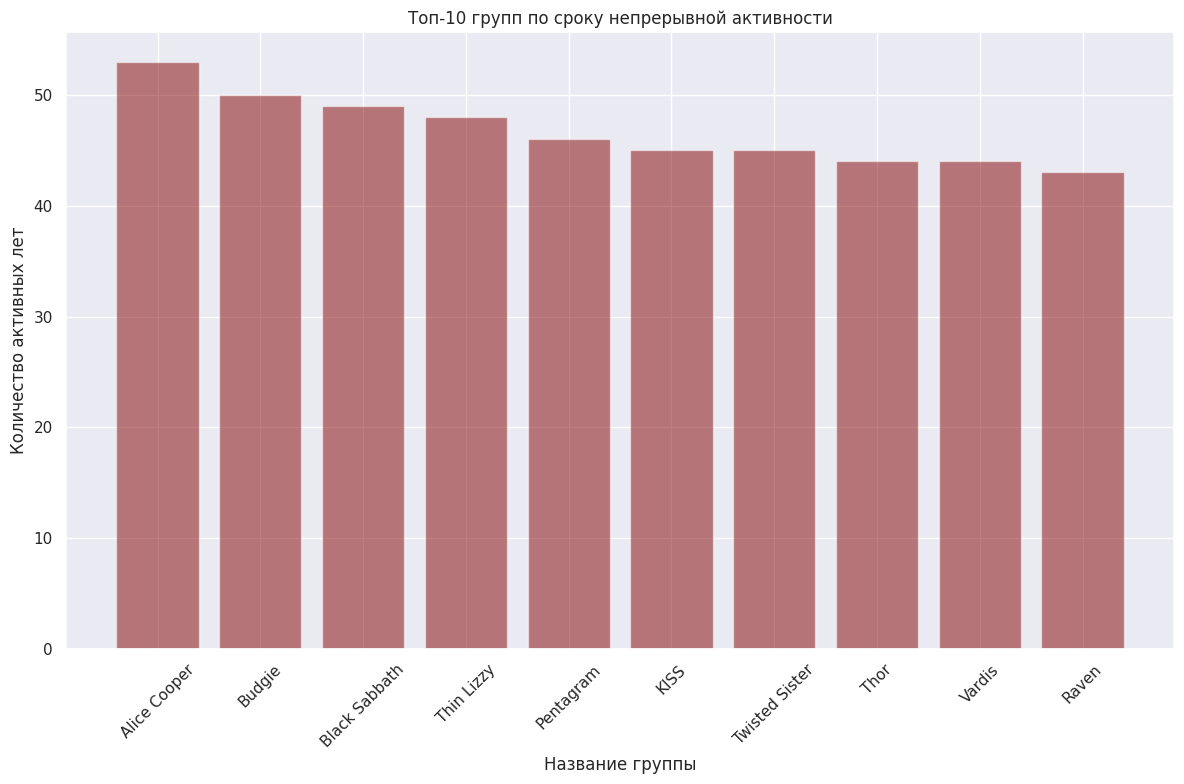

In [171]:
top_10_years = df_metal.nlargest(10, 'num_of_active_yrs')

sns.set(rc={'figure.figsize': (12, 8)})
bars = plt.bar(
    top_10_years['band_name'],
    top_10_years['num_of_active_yrs'],
    color='#800000',
    alpha=0.5,
)
plt.xlabel('Название группы')
plt.ylabel('Количество активных лет')
plt.title('Топ-10 групп по сроку непрерывной активности')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

А вот и они, ветераны метал-сцены!

Теперь смотрим самые популярные, исходя из голосов пользователей сайта, группы.

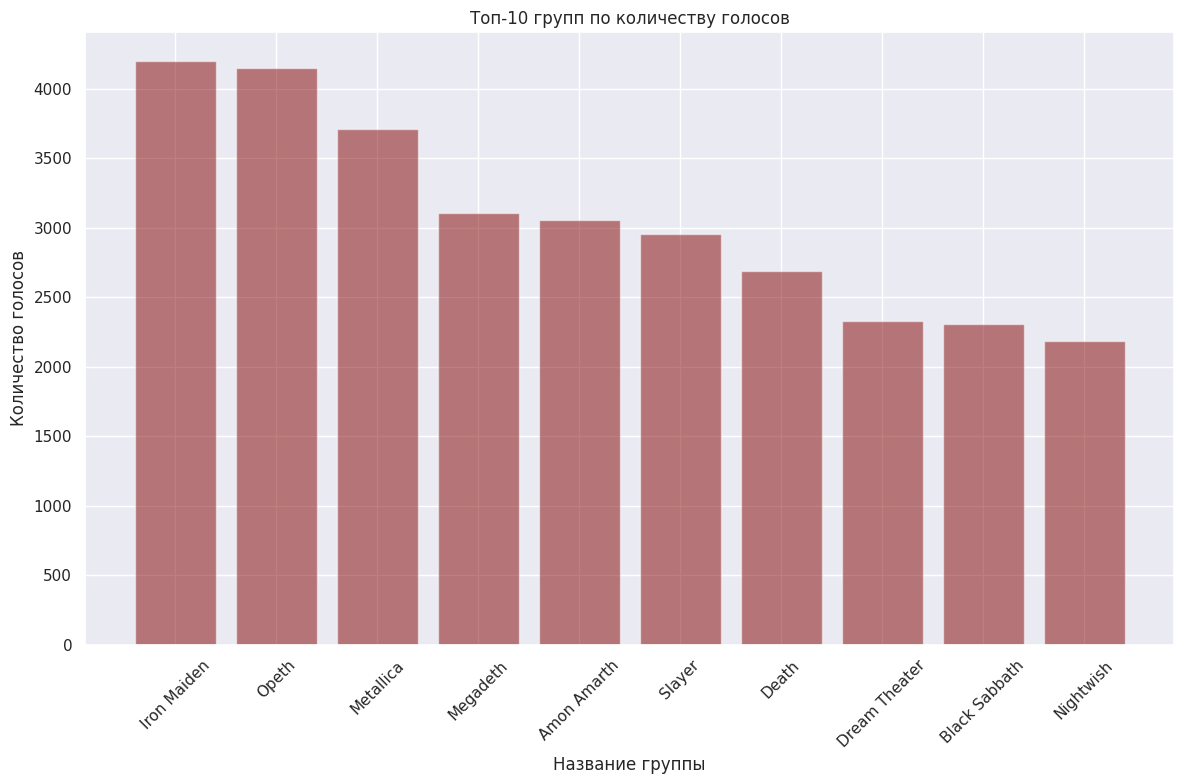

In [172]:
top_10_fans = df_metal.nlargest(10, 'fans')

sns.set(rc={'figure.figsize': (12, 8)})
bars = plt.bar(
    top_10_fans['band_name'], top_10_fans['fans'], color='#800000', alpha=0.5
)
plt.xlabel('Название группы')
plt.ylabel('Количество голосов')
plt.title('Топ-10 групп по количеству голосов')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Конечно, исходя из данных только с одного сайта, делать глобальные выводы о популярности групп в целом смысла нет, но, учитывая то, какие названия групп попали в данный топ, мне кажется, что это недалеко от реальности :)

Сгруппируем группы по году создания и посмотрим, как менялось количество создаваемых новых метал-команд от года к году.

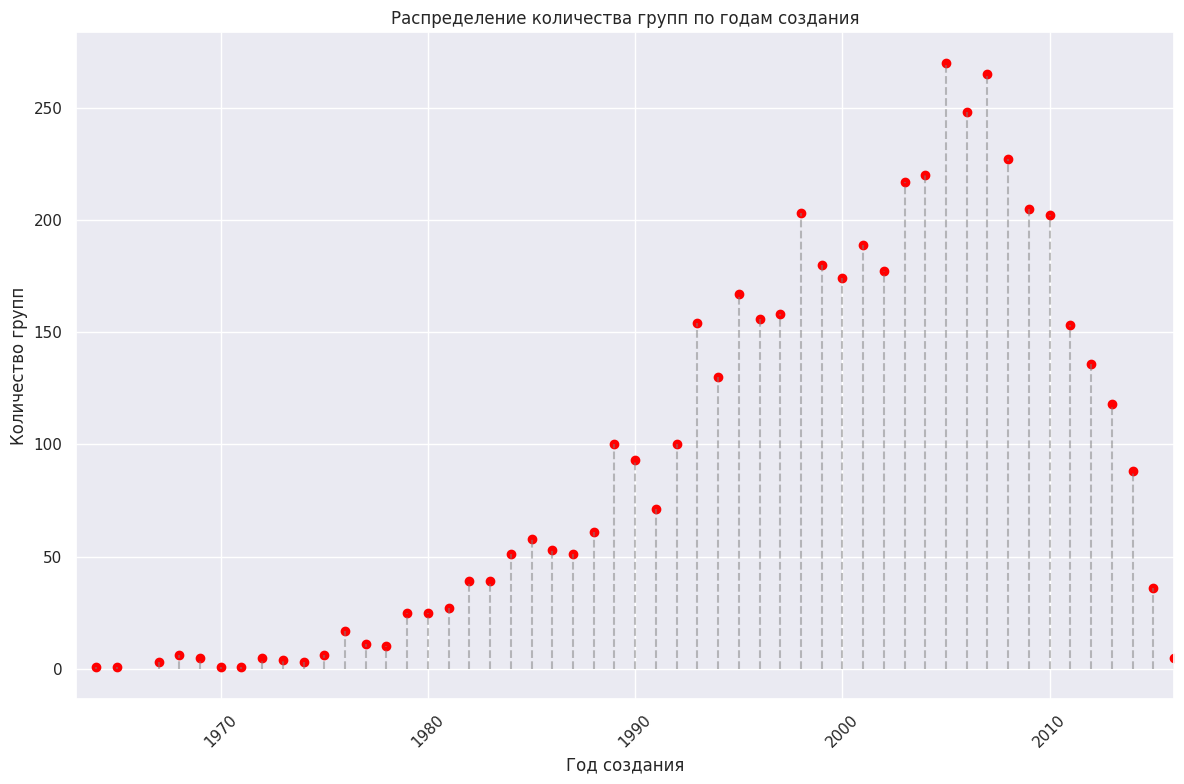

In [173]:
band_years_count = df_metal.groupby('formed').size().reset_index(name='count')

sns.set(rc={'figure.figsize':(12, 8)})
plt.scatter(
    band_years_count['formed'], band_years_count['count'], color='red', marker='o'
)
plt.xlabel('Год создания')
plt.ylabel('Количество групп')
plt.title('Распределение количества групп по годам создания')
plt.xlim(1963, 2016)
plt.xticks(rotation=45)

for index, row in band_years_count.iterrows():
    plt.vlines(
        row['formed'], 0, row['count'], linestyle='dashed', colors='gray', alpha=0.5
    )

plt.tight_layout()

Видим, что ощутимый рост метал-индустрии в виде резкого увеличения количества созданных новых групп пошёл с конца 80-ых - начала 90-ых, а после 2010 постепенно пошла тенденция на спад. Глобальная популярность тяжёлой музыки падает, соответственно, и новых групп появляется меньше.

Посмотрим, как менялось количество активных групп от года к году.

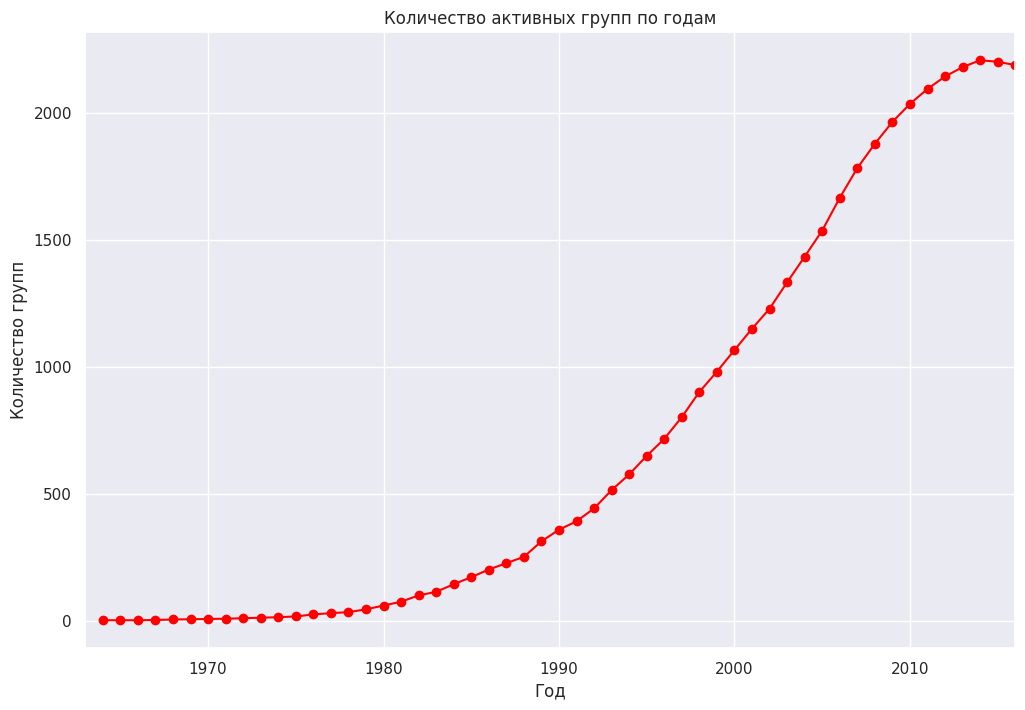

In [174]:
current_year = 2016
grouped_formed = df_metal.groupby('formed').size().reset_index(name='count_formed')
grouped_split = df_metal.groupby('split').size().reset_index(name='count_split')

years_range = range(
    min(df_metal['formed'].min(), df_metal['split'].min()), current_year + 1
)
grouped_years = pd.DataFrame({'year': years_range})
grouped_years['count'] = grouped_years['year'].apply(
    lambda year: grouped_formed[grouped_formed['formed'] <= year]['count_formed'].sum()
    - grouped_split[grouped_split['split'] <= year]['count_split'].sum()
)

sns.set(rc={'figure.figsize':(12, 8)})
plt.plot(grouped_years['year'], grouped_years['count'], marker='o', color='red')
plt.xlabel('Год')
plt.ylabel('Количество групп')
plt.title('Количество активных групп по годам')
plt.grid(True)
plt.xlim(1963, 2016)

plt.show()

Количество активных групп от года к году росло, спада аналогичного уменьшению количества созданных новых метал-групп после 2010-го года, мы тут не наблюдаем: новых групп появляется меньше, но многие созданные ранее сохраняют свою активность.

Теперь посмотрим разделенеие по географическому признаку. Для начала воспользуемся самым простым решением данной проблемы: сгруппируем музгруппы по их родине и посчитаем их количество.

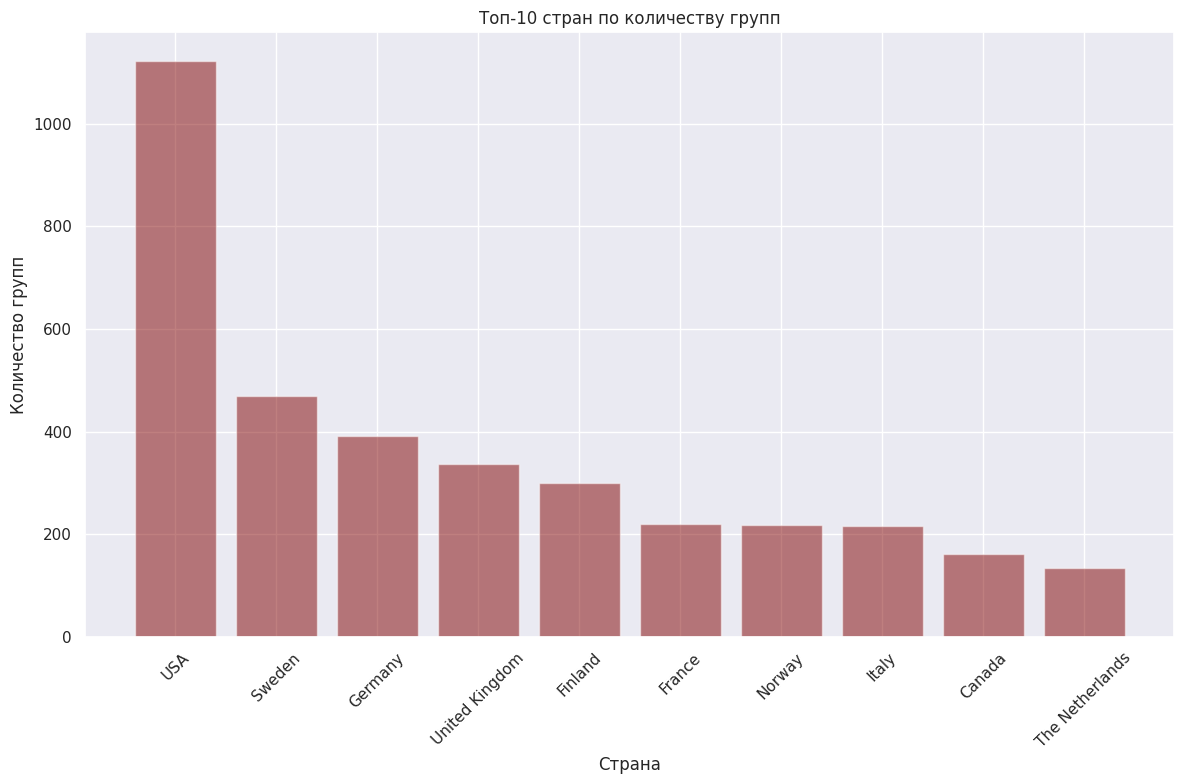

In [175]:
top_10_countries = df_metal['origin'].value_counts().head(10)

sns.set(rc={'figure.figsize': (12, 8)})
bars = plt.bar(
    top_10_countries.index, top_10_countries.values, color='#800000', alpha=0.5
)
plt.xlabel('Страна')
plt.ylabel('Количество групп')
plt.title('Топ-10 стран по количеству групп')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

В одном топе (причём даже не на разных его концах) оказались огромные США и маленькая Финляндия...делаем вполне логичный вывод: подобный анализ, заключающийся в простом подсчёте количества групп, не говорит ровным счётом ничего. Необходимо считать не по общему количеству групп, когда-либо созданных в каждой из стран, а по отношению количества групп к населению страны. Тогда-то мы и узнаем, где сильнее всего развита метал-сцена, а где большое музгрупп вызвано просто общим большим количеством населения.

Для начала внимательнее разберёмся с географическими данными, посмотрим, какие вообще страны представлены в наших данных.

In [176]:
df_metal['origin'].unique()

array(['United Kingdom', 'Sweden', 'USA', 'Finland', 'Germany', 'Poland',
       'Norway', 'The Netherlands', 'Switzerland', 'France', 'Brazil',
       'Portugal', 'Australia', 'Greece', 'Italy', 'United Kingdom, USA',
       'Austria', 'Canada', 'Israel', 'Denmark, USA', 'Ireland',
       'Faroe Islands', 'Denmark', 'Russia', 'Ukraine', 'Spain',
       'Israel, The Netherlands', 'Iceland', 'Andorra', 'Tunisia, France',
       'Belgium', 'Romania', 'Chile', 'Japan', 'Colombia, USA', 'Taiwan',
       'Hungary, United Kingdom', 'unknown', 'Hungary', 'New Zealand',
       'Greece, Sweden', 'Sweden, Finland', 'Australia, United Kingdom',
       'Estonia', 'Jordan', 'Latvia', 'Slovenia', 'Iran', 'Mexico',
       'Argentina', 'Turkey', 'UAE', 'Liechtenstein', 'Czech Republic',
       'Norway, Finland', 'Serbia', 'Belgium, United Kingdom', 'Egypt',
       'Russia, Canada', 'Indonesia', 'Iraq, USA', 'Lithuania', 'China',
       'India', 'Slovak Republic', 'Kyrgyzstan, Germany', 'Singapore',
  

Удалим страны с заглушкой 'unknonw', в данном случае они больше не нужны, и приведём Южную Корею в правильный вид.

In [177]:
df_metal.drop(df_metal[df_metal['origin'] == 'unknown'].index, inplace=True)
df_metal['origin'] = df_metal['origin'].replace('Korea, South', 'South Korea')

In [178]:
filtered_df_metal_origin = df_metal[df_metal['origin'].str.contains(',')]
filtered_df_metal_origin

,band_name,fans,formed,origin,split,style,num_of_active_yrs
129,Motörhead,875,1975,"United Kingdom, USA",1975,Heavy,0
147,Ozzy Osbourne,750,1979,"United Kingdom, USA",1979,Heavy,0
159,King Diamond,641,1985,"Denmark, USA",1985,Heavy,0
194,Mercyful Fate,525,1981,"Denmark, USA",2017,"Heavy,First wave of black",36
295,Melechesh,307,1993,"Israel, The Netherlands",1993,"Melodic black,Folk",0
319,Myrath,275,2001,"Tunisia, France",2001,"Progressive,Oriental folk",0
448,Inquisition,184,1988,"Colombia, USA",2017,"Black,Thrash",29
459,Thy Catafalque,177,1998,"Hungary, United Kingdom",1998,Avantgarde black,0
545,Nightrage,138,2000,"Greece, Sweden",2000,Melodic death,0
557,Sinergy,134,1997,"Sweden, Finland",1997,"Heavy,Power",0


Обнаружено, что у межданородных музыкальных проектов указаны сразу две страны, видимо, по происхождению участников этих групп. Дальнейшую идею я подглядел на кэггле, но реализовывал по-своему: мы создадим для каждой такой группе по две строки с разными странами, а исходные с 'двойным гражданством' удалим. Также в итоговой таблице приведём название Соединённых Штатов к стандартному виду.

In [179]:
df_metal_copy = df_metal.copy()
df_metal_copy['origin'] = df_metal_copy['origin'].str.split(', ')
df_exploded = df_metal_copy.explode('origin')
df_exploded_cleaned = df_exploded.drop_duplicates()

In [180]:
geo = df_exploded_cleaned['origin'].value_counts()
result_df = pd.DataFrame({'name': geo.index, 'num_of_bands': geo.values})
result_df['name'] = result_df['name'].replace('USA', 'United States of America')

С помощью GeoPandas загружаем информацию о странах, карту мира (без бесполезной для нас Антарктики), объединяем с нашей финальной таблицей. Добавляем столбец с количеством метал групп на душу населения в каждой из стран и отмечаем этот параметр на карте. Страны, не представленные в нашем датасете, будут отмечены серым цветом.

<ipython-input-181-cb977e4c98ab>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


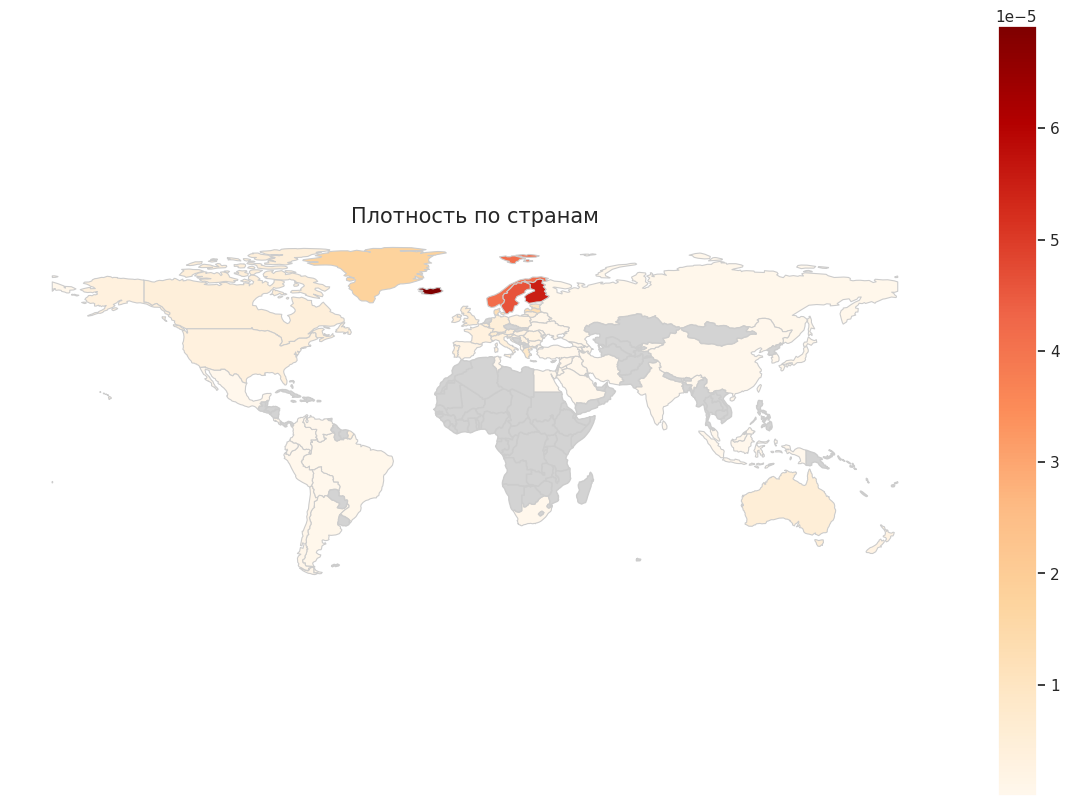

In [181]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world['name'] != 'Antarctica')]

merged = world.merge(result_df, left_on='name', right_on='name', how='left')
merged['ratio'] = merged['num_of_bands'] / merged['pop_est']

countries_without_data = merged[merged['ratio'].isnull()]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

merged[merged['ratio'].notnull()].plot(
    column='ratio', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True
)

countries_without_data.plot(ax=ax, color='lightgray', edgecolor='0.8')

ax.set_title('Плотность по странам', fontdict={'fontsize': '15', 'fontweight': '3'})
ax.set_axis_off()

plt.show()

## Выводы по разделу.
В топе Исландия, Финляндия, скандинавские страны. Вот мы и подтвердили своим исследованием: не зря метал музыка в первую очердь зачастую ассоциируется со Скандинавией (не столько даже строго в географическом, сколько в культурном смысле).

# Общие выводы.

Основные выводы, сделанные в ходе выполнения данного проекта:



- Половина метал групп из наших данных распалась в тот же год, что и были созданы. Среднеарифметический срок жизни группы из нашего датасета составляет примерно 7 лет 9 месяцев. Максимальный срок жизни - 53 года.

- Из поджанров метала лидируют Death, Black, Progressive, Doom и Heavy.

- Исполнители - лидеры по длине жизни своих проектов: Alice Cooper, Budgie, Black Sabbath.

- Самые популярные у пользователей сайта, откуда взята рассматриваемая информация, группы:  Iron Maiden, Opeth, Metallica.

- Наибольшая плотность металл групп на душу населения в Исландии, Финляндии и Швеции.